# LLM - ChatGPT - OpenAI

El objetivo de este Notebook es realizar la evaluación de diferentes modelos de OpenAI para clasificar el texto en emociones. Se utilizan diferentes métodos de transfer learning y de fine tunning con el fin de encontrar el mejor modelo.

## Libraries

In [2]:
import json
import os
from pathlib import Path
import pandas as pd
from dotenv import load_dotenv
from openai import OpenAI


## Dataset

Se cargan los datasets de `training`, `validation` y `test` que se han utilizado en otros modelos para garantizar consistencia al momento de comparar los resultados. Cada uno de estos datasets contiene dos variables **text** y **emotion**

In [9]:
df_train = pd.read_csv("../data/data_to_model/train_data.csv")
df_val = pd.read_csv("../data/data_to_model/val_data.csv")
df_test = pd.read_csv("../data/data_to_model/test_data.csv")

In [10]:
df_train.head()

,text,emotion
0,when the week for exams came i got afraid as t...,fear
1,i was sleeping when i heard the neighbours scr...,fear
2,there was a time when my room looked terribly ...,shame
3,when my friend told me that he would come and ...,joy
4,"when i saw the film ""johnny got his gun"" which...",sadness


## OpenAI Client Configuration

En este paso se configura el cliente con el API Key previamente generada en https://platform.openai.com/settings/profile?tab=api-keys

Es importante mencionar que el uso de esta API consume créditos (dinero), por lo tanto, no se hace pública y para reproducir el Notebook deben configurar su propia API Key en el archivo `.env` con el siguiente formato:

OPENAI_API_KEY = sk-xxxxxxxxx

In [4]:
load_dotenv()

True

In [5]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

## Data Formating

Rename columns of Dataframe

In [13]:
df_train.rename(columns={"text": "prompt", "emotion": "completion"}, inplace=True)
df_val.rename(columns={"text": "prompt", "emotion": "completion"}, inplace=True)
df_test.rename(columns={"text": "prompt", "emotion": "completion"}, inplace=True)

## Transfer Learning

Los LLM han sido entrenados con enormes volumenes de datos y han guardado en sus parametros todo lo aprendido en este proceso. El proceso de Transfer Learning consiste en utilizar dichos modelos pre entrenados con sus parámetros para tareas específicas sin realizar entrenamientos adicionales.

En este caso solo se utiliza el conjunto de datos de pruebas para poder comparar las métricas con el método de fine-tuning

**Note**: Understanting  `chat.competitions` function of OpenAI API : https://medium.com/@csakash03/model-parameters-in-openai-api-fe6101d3f813

## `gpt-4o-mini` Model

In [130]:
# System message defining the role and task for the model
system_message = """
You are an advanced assistant specialized in analyzing and detecting emotions in short text. 
You will be provided with a text, and your task is to classify it into **exactly one emotion** from the following list:
[shame, sadness, joy, guilt, fear, disgust, anger].

**Important Rules:**
1. You must return only **one** of the emotions from the list without aditional text.
2. Do **not** create or infer any emotions outside the list.
3. If the text does not match any emotion exactly, return the closest emotion from the list. 
4. Do **not** return 'None', 'jealousy', or any other emotion that is not in the list.
5. Do not return aditional text, only **exactly one emotion** of the list.

Your answer only could be shame, sadness, joy, guilt, fear, disgust or anger
You are not allowed to return None, if you are not sure about the emotion, assign the closest emotion from the allowed list


For example:

Text: when the week for exams came I got afraid as to how I would tackle the questions.
Response: fear
"""


# Function to create the user message (prompt) for emotion detection
def create_user_message(row):
    return f"{row['prompt']}"  # \n\nWhat is the emotion expressed in this text?"


# Initialize an empty column to store the predictions
df_test["predicted_emotion"] = (
    None  # Create a new column for storing the predicted emotions
)

# Iterate over each row in df_test
for index, row in df_test.iterrows():
    test_messages = []

    # Append system message and user message
    test_messages.append({"role": "system", "content": system_message})
    user_message = create_user_message(row)
    test_messages.append({"role": "user", "content": user_message})

    # Call the fine-tuned model for emotion classification
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=test_messages,
        temperature=0.2,
        max_tokens=7,
        top_p=1,
    )

    # Extract the model's response (predicted emotion)
    predicted_emotion = response.choices[0].message.content.strip()

    # Store the predicted emotion in the new column
    df_test.at[index, "predicted_emotion"] = predicted_emotion

# Display the dataframe with the predicted emotions
df_test.head()

,prompt,completion,predicted_emotion
0,when a friend carelessly broke and object in m...,anger,anger
1,when i felt powerless to help the poor or when...,sadness,sadness
2,one of my best friends'fianct broke off the re...,shame,shame
3,i hadn't been at my parent's place for a long ...,sadness,sadness
4,when i didn't notify someone that he was summo...,guilt,guilt


Classification Report:
              precision    recall  f1-score   support

       anger       0.76      0.62      0.68       109
     sadness       0.81      0.67      0.73       107
       shame       0.90      0.82      0.86       109
       guilt       0.66      0.78      0.72       106
     disgust       0.94      0.96      0.95       109
        fear       0.64      0.90      0.75       108
         joy       0.66      0.54      0.59       106

    accuracy                           0.76       754
   macro avg       0.77      0.76      0.75       754
weighted avg       0.77      0.76      0.76       754



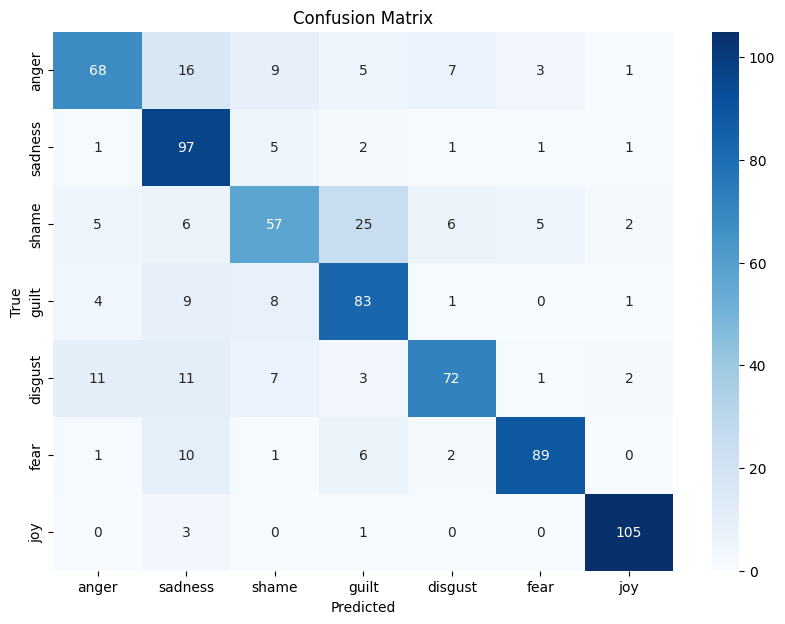

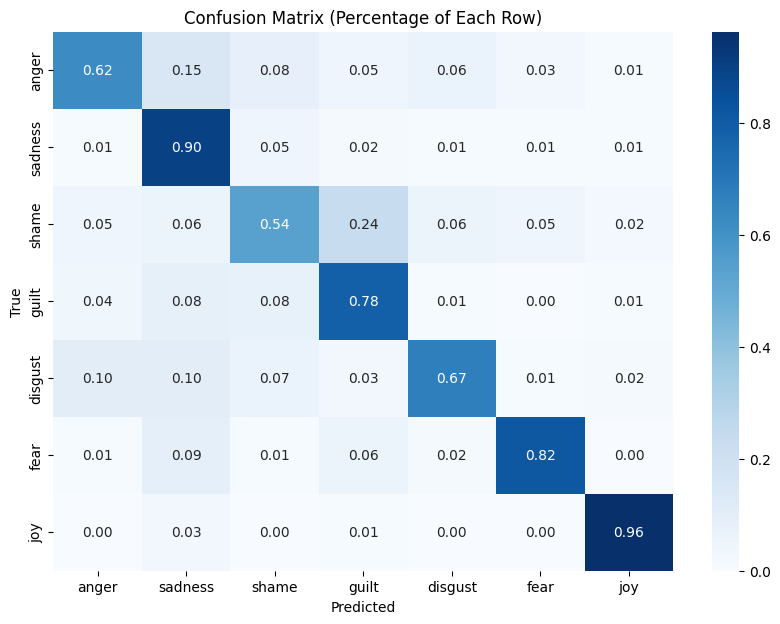

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,gpt-4o-mini,Transfer Learning,0.757294,0.765481,0.756496,0.754221


In [133]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    df_test["completion"],
    df_test["predicted_emotion"],
    output_dict=True,
    target_names=df_test["completion"].unique(),
)
print(
    classification_report(
        df_test["completion"],
        df_test["predicted_emotion"],
        target_names=df_test["completion"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": "gpt-4o-mini",
        "Method": "Transfer Learning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convert results to a DataFrame
results_df_tl = pd.DataFrame(results)


# Step 2: Confusion matrix
conf_matrix = confusion_matrix(
    df_test["completion"],
    df_test["predicted_emotion"],
    labels=df_test["completion"].unique(),
)

# Convert confusion matrix to DataFrame for better plotting
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=df_test["completion"].unique(),
    columns=df_test["completion"].unique(),
)

# Step 3: Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Step 1: Compute confusion matrix
conf_matrix = confusion_matrix(
    df_test["completion"],
    df_test["predicted_emotion"],
    labels=df_test["completion"].unique(),
)

# Step 2: Normalize the confusion matrix row-wise (i.e., as percentages)
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Step 3: Convert the normalized confusion matrix to a DataFrame for plotting
conf_matrix_normalized_df = pd.DataFrame(
    conf_matrix_normalized,
    index=df_test["completion"].unique(),
    columns=df_test["completion"].unique(),
)

# Step 4: Plot the normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Confusion Matrix (Percentage of Each Row)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


results_df_tl

## Fine Tuning

El proceso de Fine Tuning consiste en tomar los modelos pre entrenados y ajustar su ultima capa con nuestros datos para que aprendan dicho contexto específico que no vieron en su proceso de entrenamiento original.

**Modelos disponibles**:

A la fecha de este desarrollo, OpenAI tiene los siguientes modelos disponibles para fine-tuning:
* gpt-4o-2024-08-06
* gpt-4o-mini-2024-07-18
* gpt-4-0613
* gpt-3.5-turbo-0125
* gpt-3.5-turbo-1106
* babbage-002
* davinci-002

**Notas importantes**: 
* `babbage-002` y `davinci-002` no son modelos de formato de chat, son modelos de prompt completition, lo que lo hace especializados en completar palabras faltantes en texto. Por lo tanto, no serán utilizados en este proceso de comparación. 
* Por restricciones presupuestales, solo se realizará fine-tuning de una versión de `gpt-3.5-turbo`.
* Se probaran la versión mini de `gpt-4o` por restricciones presupuestales y eficiencia computacional.

**Step-by-step**:

A un primer nivel este proceso involucra los siguientes pasos:
1. Preparar y cargar la data
2. Entrenar un nuevo modelo fine-tuneado
3. Evaluar los resultados
4. Usar el modelo Fine-tuneado.

## Fine-tuning `gpt-4o-mini-2024-07-18`

### 1. Prepare and load the data

#### 1.1. Prepare data 

La API de OpenAI necesita que los datos sean formateados en tipo conversación con la API, por ejemplo:

{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}

##### **A) Function to format DataFrame** : 
Los dataframes deben ser transformatos al formato aceptado por lo modelos

In [14]:
# Initial promt that give to the model a role and task
system_message = "You are an advanced assistant specialized in analyzing and detecting emotions in short text. Your role is to identify the underlying emotion conveyed in each input and provide the most accurate emotional classification between: shame, sadness, joy, guilt, fear, disgust and anger"


# Function to create the user message (prompt) for emotion detection
def create_user_message(row):
    return f"Text: {row['prompt']}\n\nWhat is the emotion expressed in this text?"


# Function to prepare an example conversation
def prepare_example_conversation(row):
    return {
        "messages": [
            {
                "role": "system",
                "content": system_message,
            },  # Use your system message focused on emotion detection
            {"role": "user", "content": create_user_message(row)},
            {
                "role": "assistant",
                "content": row["completion"],
            },  # Emotion label from your dataset
        ]
    }


# Result
prepare_example_conversation(df_train.iloc[0])

{'messages': [{'role': 'system',
   'content': 'You are an advanced assistant specialized in analyzing and detecting emotions in short text. Your role is to identify the underlying emotion conveyed in each input and provide the most accurate emotional classification between: shame, sadness, joy, guilt, fear, disgust and anger'},
  {'role': 'user',
   'content': 'Text: when the week for exams came i got afraid as to how i would tackle the questions\n\nWhat is the emotion expressed in this text?'},
  {'role': 'assistant', 'content': 'fear'}]}

In [15]:
# apply the prepare_example_conversation function to each row of the training_df
training_data = df_train.apply(prepare_example_conversation, axis=1).tolist()
validation_data = df_val.apply(prepare_example_conversation, axis=1).tolist()

In [18]:
training_data[0:3]

[{'messages': [{'role': 'system',
    'content': 'You are an advanced assistant specialized in analyzing and detecting emotions in short text. Your role is to identify the underlying emotion conveyed in each input and provide the most accurate emotional classification between: shame, sadness, joy, guilt, fear, disgust and anger'},
   {'role': 'user',
    'content': 'Text: when the week for exams came i got afraid as to how i would tackle the questions\n\nWhat is the emotion expressed in this text?'},
   {'role': 'assistant', 'content': 'fear'}]},
 {'messages': [{'role': 'system',
    'content': 'You are an advanced assistant specialized in analyzing and detecting emotions in short text. Your role is to identify the underlying emotion conveyed in each input and provide the most accurate emotional classification between: shame, sadness, joy, guilt, fear, disgust and anger'},
   {'role': 'user',
    'content': "Text: i was sleeping when i heard the neighbours screaming, i peeped through t

##### **B) Convert into json**
La data se debe convertir a json para que sea aceptada por la API de OpenAI

In [19]:
# Function to convert data to json and save it
def write_jsonl(data_list: list, filename: str) -> None:
    with open(filename, "w") as out:
        for ddict in data_list:
            jout = json.dumps(ddict) + "\n"
            out.write(jout)

In [20]:
# Saving training and validation data to model
training_file_name = "../data/data_to_openai/tmp_isear_finetune_training.jsonl"
write_jsonl(training_data, training_file_name)

validation_file_name = "../data/data_to_openai/tmp_isear_finetune_validation.jsonl"
write_jsonl(validation_data, validation_file_name)

#### 1.2. Data Loading

La data preprocesada debe ser cargada a la plataforma de OpenAI para que pueda ser usada en tareas de Fine-tuning. Este proceso solo debe hacerse una vez

In [36]:
## Uncoment if it's the first time that you will load the data

## Upload the training file
# train_file = client.files.create(file=Path(training_file_name), purpose="fine-tune")
#
# train_file_id = train_file.id
#
## Upload the validation file
# valid_file = client.files.create(file=Path(validation_file_name), purpose="fine-tune")
#
# valid_file_id = valid_file.id
#
# print(f"Training file ID: {train_file_id}")
# print(f"Validation file ID: {valid_file_id}")

Training file ID: file-CzKxkJK2duXiM9mWRg804hf9
Validation file ID: file-tM1BpBNLWZ5byOmaVwUmBhNG


In [22]:
train_file_id = "file-CzKxkJK2duXiM9mWRg804hf9"
valid_file_id = "file-tM1BpBNLWZ5byOmaVwUmBhNG"

print(f"Training file ID: {train_file_id}")
print(f"Validation file ID: {valid_file_id}")

Training file ID: file-CzKxkJK2duXiM9mWRg804hf9
Validation file ID: file-tM1BpBNLWZ5byOmaVwUmBhNG


### 2. Train a new fine-tuning model

Se le indica a la API los ID de los datos de  `training` y `validation`. Además del Modelo y un sufijo para su ID. Este proceso solo se realiza una vez y posteriormente se utiliza el id del modelo para probarlo en test y en producción.

In [33]:
## Uncoment if it's the first time executing the process.

MODEL = "gpt-4o-mini-2024-07-18"
#
## Start the fine-tuning process
# response = client.fine_tuning.jobs.create(
#    training_file=train_file_id,
#    validation_file=valid_file_id,
#    model=MODEL,  # Replace with the base model you'd like to use
#    suffix="isear",  # Specify the number of epochs
# )
#
#
# job_id = response.id
#
# print("Job ID:", response.id)
# print("Status:", response.status)

In [23]:
job_id = "ftjob-L1OzISnyQRSsWZgkp9ok1pGm"

print("Job ID:", job_id)

Job ID: ftjob-L1OzISnyQRSsWZgkp9ok1pGm


In [52]:
## This block of code is used to check the status of finetuning

## Check status
# response = client.fine_tuning.jobs.retrieve(job_id)
#
# print("Job ID:", response.id)
# print("Status:", response.status)
# print("Trained Tokens:", response.trained_tokens)

Job ID: ftjob-L1OzISnyQRSsWZgkp9ok1pGm
Status: validating_files
Trained Tokens: None


In [65]:
# Check the progress
response = client.fine_tuning.jobs.list_events(job_id)

events = response.data
events.reverse()

for event in events:
    print(event.message)

Step 1492/1507: training loss=0.05
Step 1493/1507: training loss=0.02
Step 1494/1507: training loss=0.16
Step 1495/1507: training loss=0.12
Step 1496/1507: training loss=0.18
Step 1497/1507: training loss=0.10
Step 1498/1507: training loss=0.02
Step 1499/1507: training loss=0.11
Step 1500/1507: training loss=0.03, validation loss=0.21
Step 1501/1507: training loss=0.13
Step 1502/1507: training loss=0.03
Step 1503/1507: training loss=0.13
Step 1504/1507: training loss=0.02
Step 1505/1507: training loss=0.15
Step 1506/1507: training loss=0.10, full validation loss=0.23
Step 1507/1507: training loss=0.02
Checkpoint created at step 1004
Checkpoint created at step 1506
New fine-tuned model created
The job has successfully completed


In [66]:
response = client.fine_tuning.jobs.retrieve(job_id)
fine_tuned_model_id = response.fine_tuned_model

if fine_tuned_model_id is None:
    raise RuntimeError(
        "Fine-tuned model ID not found. Your job has likely not been completed yet."
    )

print("Fine-tuned model ID:", fine_tuned_model_id)

Fine-tuned model ID: ft:gpt-4o-mini-2024-07-18:personal:isear:AGJrpluF


### 3. Testing fine tunned model

#### Testint 1 row

In [26]:
df_test.head()

,prompt,completion
0,when a friend carelessly broke and object in m...,anger
1,when i felt powerless to help the poor or when...,sadness
2,one of my best friends'fianct broke off the re...,shame
3,i hadn't been at my parent's place for a long ...,sadness
4,when i didn't notify someone that he was summo...,guilt


In [27]:
df_test.iloc[0]

prompt        when a friend carelessly broke and object in m...
completion                                                anger
Name: 0, dtype: object

In [29]:
test_row = df_test.iloc[0]
test_messages = []
test_messages.append({"role": "system", "content": system_message})
user_message = create_user_message(test_row)
test_messages.append({"role": "user", "content": user_message})

print(test_messages)

[{'role': 'system', 'content': 'You are an advanced assistant specialized in analyzing and detecting emotions in short text. Your role is to identify the underlying emotion conveyed in each input and provide the most accurate emotional classification between: shame, sadness, joy, guilt, fear, disgust and anger'}, {'role': 'user', 'content': "Text: when a friend carelessly broke and object in my parent's house and did not apologize, or pay, or anything\n\nWhat is the emotion expressed in this text?"}]


In [30]:
response = client.chat.completions.create(
    model=fine_tuned_model_id, messages=test_messages, temperature=0, max_tokens=500
)
print(response.choices[0].message.content)

anger


#### Evaluating with all Testing data

In [31]:
# Initialize an empty list to store the predictions
df_test["predicted_emotion"] = (
    None  # Create a new column for storing the predicted emotions
)

# Iterate over each row in df_test
for index, row in df_test.iterrows():
    test_messages = []

    # Append system message and user message
    test_messages.append({"role": "system", "content": system_message})
    user_message = create_user_message(row)
    test_messages.append({"role": "user", "content": user_message})

    # Call the fine-tuned model for emotion classification
    response = client.chat.completions.create(
        model=fine_tuned_model_id, messages=test_messages, temperature=0, max_tokens=500
    )

    # Extract the model's response (predicted emotion)
    predicted_emotion = response.choices[0].message.content.strip()

    # Store the predicted emotion in the new column
    df_test.at[index, "predicted_emotion"] = predicted_emotion

# Display the dataframe with the predicted emotions
df_test.head()

,prompt,completion,predicted_emotion
0,when a friend carelessly broke and object in m...,anger,anger
1,when i felt powerless to help the poor or when...,sadness,guilt
2,one of my best friends'fianct broke off the re...,shame,shame
3,i hadn't been at my parent's place for a long ...,sadness,sadness
4,when i didn't notify someone that he was summo...,guilt,guilt


#### Calculating Metrics for test set

Classification Report:
              precision    recall  f1-score   support

       anger       0.70      0.76      0.73       109
     sadness       0.83      0.74      0.78       107
       shame       0.92      0.87      0.90       109
       guilt       0.79      0.76      0.78       106
     disgust       0.92      0.99      0.96       109
        fear       0.81      0.81      0.81       108
         joy       0.74      0.76      0.75       106

    accuracy                           0.82       754
   macro avg       0.82      0.82      0.82       754
weighted avg       0.82      0.82      0.82       754



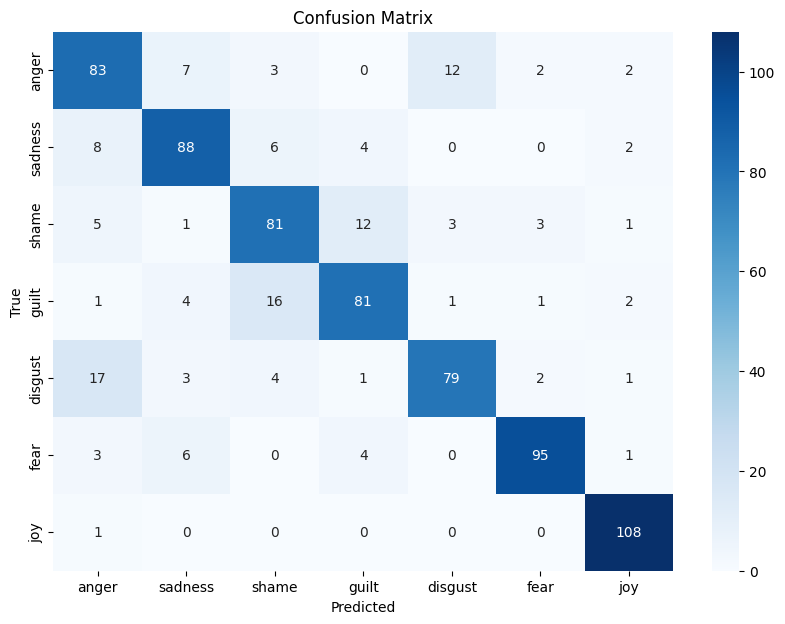

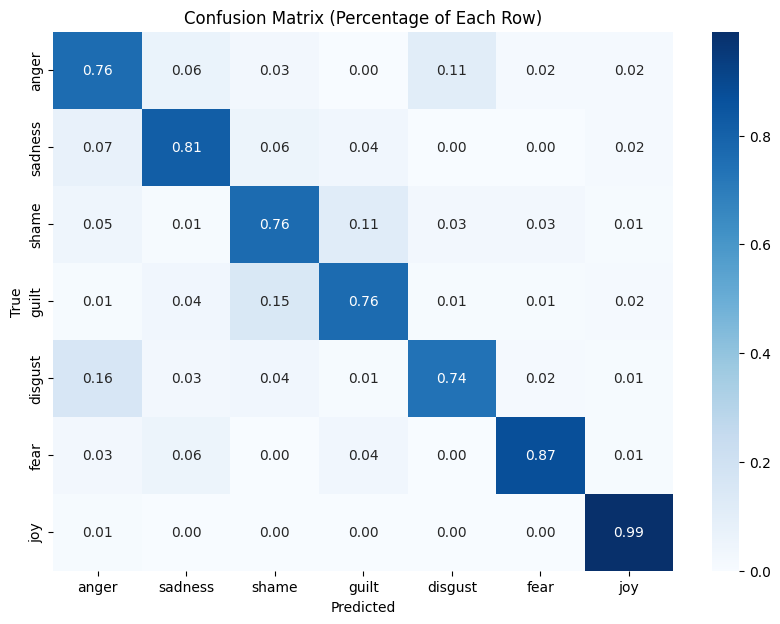

,Model,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,gpt-4o-mini-2024-07-18,0.81565,0.816885,0.815041,0.815049


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    df_test["completion"],
    df_test["predicted_emotion"],
    output_dict=True,
    target_names=df_test["completion"].unique(),
)
print(
    classification_report(
        df_test["completion"],
        df_test["predicted_emotion"],
        target_names=df_test["completion"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": MODEL,
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame with results


# Step 2: Confusion matrix
conf_matrix = confusion_matrix(
    df_test["completion"],
    df_test["predicted_emotion"],
    labels=df_test["completion"].unique(),
)

# Convert confusion matrix to DataFrame for better plotting
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=df_test["completion"].unique(),
    columns=df_test["completion"].unique(),
)

# Step 3: Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Step 1: Compute confusion matrix
conf_matrix = confusion_matrix(
    df_test["completion"],
    df_test["predicted_emotion"],
    labels=df_test["completion"].unique(),
)

# Step 2: Normalize the confusion matrix row-wise (i.e., as percentages)
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Step 3: Convert the normalized confusion matrix to a DataFrame for plotting
conf_matrix_normalized_df = pd.DataFrame(
    conf_matrix_normalized,
    index=df_test["completion"].unique(),
    columns=df_test["completion"].unique(),
)

# Step 4: Plot the normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Confusion Matrix (Percentage of Each Row)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


results_df

In [38]:
# Saving Model ID
from datetime import datetime

# Get current date and format it as yyyy-mm-dd
current_date = datetime.now().strftime("%Y-%m-%d")

df_model_ids = pd.DataFrame(
    [["gpt-4o-mini-2024-07-18", fine_tuned_model_id, current_date]],
    columns=["model_name", "model_id", "fine_tuning_date"],
)
df_model_ids.head()

,model_name,model_id,fine_tuning_date
0,gpt-4o-mini-2024-07-18,ft:gpt-4o-mini-2024-07-18:personal:isear:AGJrpluF,2024-10-09


## Fine-tuning `gpt-3.5-turbo-0613`

In [51]:
MODEL = "gpt-3.5-turbo-1106"

# Start the fine-tuning process
response = client.fine_tuning.jobs.create(
    training_file=train_file_id,
    validation_file=valid_file_id,
    model=MODEL,  # Replace with the base model you'd like to use
    suffix="isear",  # Specify the number of epochs
)


job_id = response.id

print("Job ID:", response.id)
print("Status:", response.status)

Job ID: ftjob-Q1yfeiWEUZa4L2ghEQtHskjj
Status: validating_files


In [55]:
# Check status
response = client.fine_tuning.jobs.retrieve(job_id)

print("Job ID:", response.id)
print("Status:", response.status)
print("Trained Tokens:", response.trained_tokens)

Job ID: ftjob-Q1yfeiWEUZa4L2ghEQtHskjj
Status: running
Trained Tokens: None


In [69]:
# Check the progress
response = client.fine_tuning.jobs.list_events(job_id)

events = response.data
events.reverse()

for event in events:
    print(event.message)

Step 1492/1507: training loss=0.27
Step 1493/1507: training loss=0.04
Step 1494/1507: training loss=0.05
Step 1495/1507: training loss=0.05
Step 1496/1507: training loss=0.06
Step 1497/1507: training loss=0.16
Step 1498/1507: training loss=0.05
Step 1499/1507: training loss=0.02
Step 1500/1507: training loss=0.10, validation loss=0.08
Step 1501/1507: training loss=0.00
Step 1502/1507: training loss=0.03
Step 1503/1507: training loss=0.15
Step 1504/1507: training loss=0.14
Step 1505/1507: training loss=0.02
Step 1506/1507: training loss=0.15, full validation loss=0.14
Step 1507/1507: training loss=0.05
Checkpoint created at step 1004
Checkpoint created at step 1506
New fine-tuned model created
The job has successfully completed


In [70]:
response = client.fine_tuning.jobs.retrieve(job_id)
fine_tuned_model_id = response.fine_tuned_model

if fine_tuned_model_id is None:
    raise RuntimeError(
        "Fine-tuned model ID not found. Your job has likely not been completed yet."
    )

print("Fine-tuned model ID:", fine_tuned_model_id)

Fine-tuned model ID: ft:gpt-3.5-turbo-1106:personal:isear:AGdiGg4q


In [71]:
# Evaluating on testing data

# Initialize an empty list to store the predictions
df_test["predicted_emotion"] = (
    None  # Create a new column for storing the predicted emotions
)

# Iterate over each row in df_test
for index, row in df_test.iterrows():
    test_messages = []

    # Append system message and user message
    test_messages.append({"role": "system", "content": system_message})
    user_message = create_user_message(row)
    test_messages.append({"role": "user", "content": user_message})

    # Call the fine-tuned model for emotion classification
    response = client.chat.completions.create(
        model=fine_tuned_model_id, messages=test_messages, temperature=0, max_tokens=500
    )

    # Extract the model's response (predicted emotion)
    predicted_emotion = response.choices[0].message.content.strip()

    # Store the predicted emotion in the new column
    df_test.at[index, "predicted_emotion"] = predicted_emotion

# Display the dataframe with the predicted emotions
df_test.head()

,prompt,completion,predicted_emotion
0,when a friend carelessly broke and object in m...,anger,anger
1,when i felt powerless to help the poor or when...,sadness,sadness
2,one of my best friends'fianct broke off the re...,shame,shame
3,i hadn't been at my parent's place for a long ...,sadness,sadness
4,when i didn't notify someone that he was summo...,guilt,guilt


Classification Report:
              precision    recall  f1-score   support

       anger       0.75      0.76      0.76       109
     sadness       0.78      0.79      0.79       107
       shame       0.92      0.86      0.89       109
       guilt       0.75      0.80      0.78       106
     disgust       0.95      0.94      0.95       109
        fear       0.83      0.80      0.82       108
         joy       0.69      0.71      0.70       106

    accuracy                           0.81       754
   macro avg       0.81      0.81      0.81       754
weighted avg       0.81      0.81      0.81       754



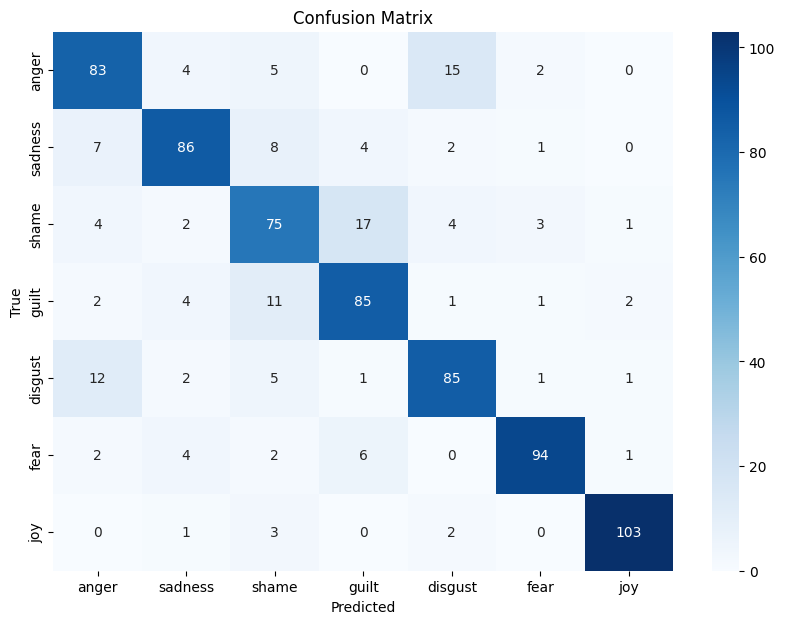

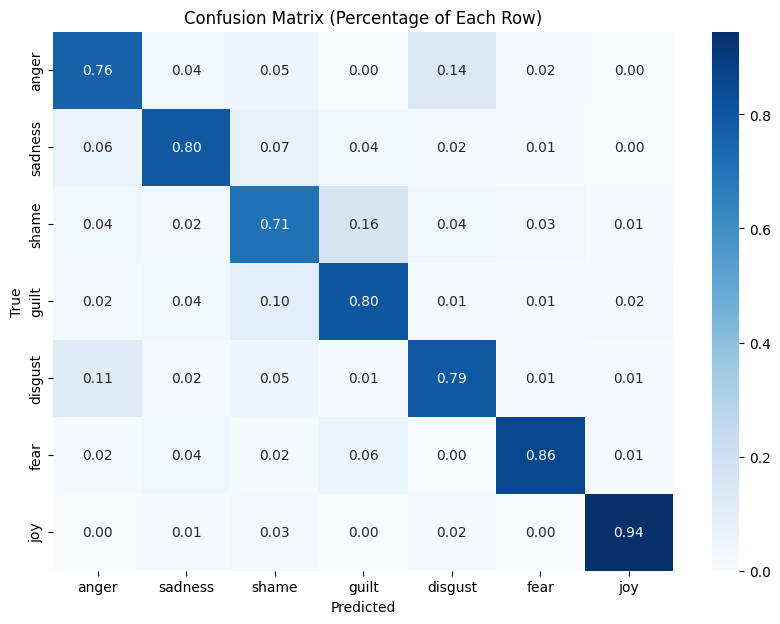

,Model,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,gpt-3.5-turbo-1106,0.810345,0.812125,0.809847,0.810633
0,gpt-4o-mini-2024-07-18,0.815650,0.816885,0.815041,0.815049


In [72]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    df_test["completion"],
    df_test["predicted_emotion"],
    output_dict=True,
    target_names=df_test["completion"].unique(),
)
print(
    classification_report(
        df_test["completion"],
        df_test["predicted_emotion"],
        target_names=df_test["completion"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": MODEL,
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convert results to a DataFrame
results_df_gpt_3_5 = pd.DataFrame(results)

# Display the DataFrame with results


# Step 2: Confusion matrix
conf_matrix = confusion_matrix(
    df_test["completion"],
    df_test["predicted_emotion"],
    labels=df_test["completion"].unique(),
)

# Convert confusion matrix to DataFrame for better plotting
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=df_test["completion"].unique(),
    columns=df_test["completion"].unique(),
)

# Step 3: Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Step 1: Compute confusion matrix
conf_matrix = confusion_matrix(
    df_test["completion"],
    df_test["predicted_emotion"],
    labels=df_test["completion"].unique(),
)

# Step 2: Normalize the confusion matrix row-wise (i.e., as percentages)
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Step 3: Convert the normalized confusion matrix to a DataFrame for plotting
conf_matrix_normalized_df = pd.DataFrame(
    conf_matrix_normalized,
    index=df_test["completion"].unique(),
    columns=df_test["completion"].unique(),
)

# Step 4: Plot the normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Confusion Matrix (Percentage of Each Row)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


results_df = pd.concat([results_df_gpt_3_5, results_df])
results_df

In [73]:
df_model_id_gpt3_5 = pd.DataFrame(
    [["gpt-3.5-turbo-1106", fine_tuned_model_id, current_date]],
    columns=["model_name", "model_id", "fine_tuning_date"],
)
df_model_ids = pd.concat([df_model_ids, df_model_id_gpt3_5])
df_model_ids.head()

,model_name,model_id,fine_tuning_date
0,gpt-4o-mini-2024-07-18,ft:gpt-4o-mini-2024-07-18:personal:isear:AGJrpluF,2024-10-09
0,gpt-3.5-turbo-1106,ft:gpt-3.5-turbo-1106:personal:isear:AGdiGg4q,2024-10-09


## Saving results and models Ids

In [144]:
results_df = pd.concat([results_df_tl, results_df])
results_df

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,method
0,gpt-4o-mini,Transfer Learning,0.757294,0.765481,0.756496,0.754221,NaN
0,gpt-3.5-turbo-1106,NaN,0.810345,0.812125,0.809847,0.810633,fine-tuning
0,gpt-4o-mini-2024-07-18,NaN,0.815650,0.816885,0.815041,0.815049,fine-tuning


In [145]:
results_df.to_excel("../data/model_results/llm_openai_models.xlsx", index=False)

In [83]:
df_model_ids.to_excel("../data/fine_tuned_models/openai_id_models.xlsx", index=False)